## Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pathlib import Path
import os
from PIL import Image
from sklearn.decomposition import PCA
import torch
from torchvision import models
import torchvision.transforms as transforms
from torchvision.models import VGG16_Weights

data_path = Path('London_UK')

# Load data
panoids = gpd.read_file(data_path / 'panoids/panoids.geojson')
network = gpd.read_file(data_path / 'network/edges/edges.geojson')

image_data = {
    'image_id': np.arange(len(panoids)),
    'panoid': panoids['panoid'],
    'longitude': panoids['lng'],
    'latitude': panoids['lat'],
}
images_df = pd.DataFrame(image_data)

In [2]:
# Create GeoDataFrame for Images
geometry = [Point(xy) for xy in zip(images_df['longitude'], images_df['latitude'])]
images_gdf = gpd.GeoDataFrame(images_df, geometry=geometry, crs=network.crs)

In [3]:
# Perform Spatial Join to find nearest street for each image 
matched = gpd.sjoin_nearest(images_gdf, network, how='left', distance_col='distance')

print(matched[['panoid', 'longitude', 'latitude', 'distance']].head())  #Dist in km

                   panoid  longitude   latitude  distance
0  wFmLm4GhS7AYVonj6tRIJw  -0.107827  51.510414  0.000473
1  ITjfv5l9KG5ImWa7eTOzAw  -0.107077  51.510418  0.000465
2  WeKFQgVRtO_lzp_4gT1HQw  -0.108574  51.510413  0.000482
3  Lm1UtkHFMqfCPgewzinz6Q  -0.108627  51.510975  0.000020
4  AU89QzVV0jU915gldn3wrQ  -0.108001  51.510957  0.000004


C:\Users\fmaca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


## Image ID to coords & Visualization

In [39]:
# Function to get coordinates by image ID
def get_coords_by_image_id(image_id):
    row = matched[matched['image_id'] == image_id]
    if not row.empty:
        return row['geometry'].values[0].x, row['geometry'].values[0].y
    else:
        return None, None 

#Example: Image ID 12 returns lat, long
get_coords_by_image_id(12)

(-0.1092318732591195, 51.5109870682374)

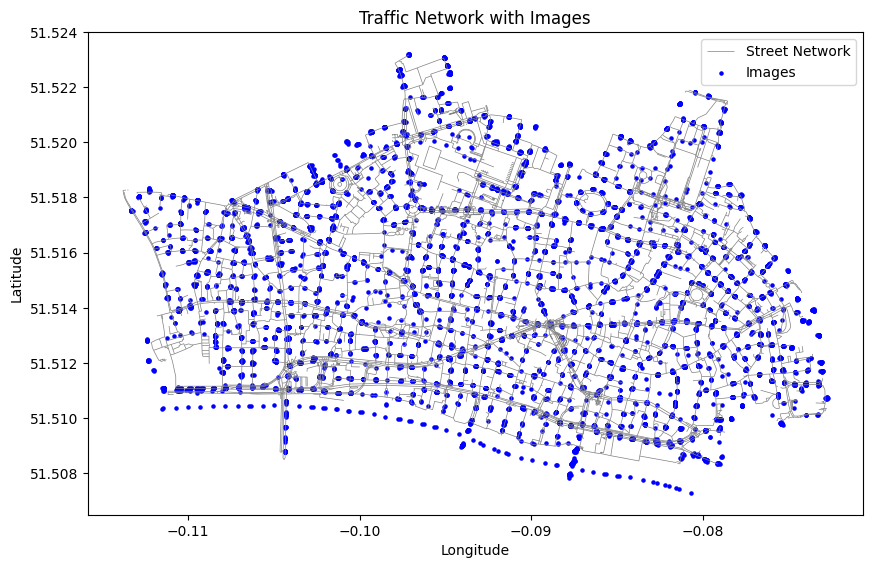

In [40]:
# Visualize the traffic network with images
fig, ax = plt.subplots(figsize=(10, 10))
network.plot(ax=ax, color='gray', linewidth=0.5, label='Street Network')
images_gdf.plot(ax=ax, color='blue', markersize=5, label='Images')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Traffic Network with Images')
plt.legend()

plt.show()

## Images to vector embeddings

In [41]:
# Load the pre-trained VGG16 model from the IMAGENET online database to use for training
vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
vgg.classifier[6] = torch.nn.Identity()  # Last layer turned into I-matrix such that the embeddings will not be trained on 1000 classes from the ImageNet database

In [44]:
# Function to load an image and transform it
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to get embeddings from the modified VGG16 model
def get_embeddings(model, image_path):
    image = load_image(image_path)
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need to track gradients
        embeddings = model(image)
    return embeddings

In [45]:
imagedb_path = Path(r"C:\Users\fmaca\OneDrive - Universidade de Lisboa\5º Ano, 1º Semestre\03 - Data Analysis and AI\03 - STREET Project\STREET - Mirror\London_UK\imagedb") #CHANGE THIS TO YOUR LOCATION
image_files = [f for f in imagedb_path.glob('*.png')]

np.random.seed(42)  
selected_images = np.random.choice(image_files, 100) #THIS TAKES N IMAGES FROM THE FOLDER AS SAMPLE

# Get embeddings for each selected image
for image_path in selected_images:
    vgg_embeddings = get_embeddings(vgg, image_path)

In [46]:
imagedb_path = Path(r"C:\Users\fmaca\OneDrive - Universidade de Lisboa\5º Ano, 1º Semestre\03 - Data Analysis and AI\03 - STREET Project\STREET - Mirror\London_UK\images") #CHANGE THIS TO YOUR LOCATION
image_files = [f for f in imagedb_path.glob('*.png')]

np.random.seed(42)  
selected_images = np.random.choice(image_files, 100) #THIS TAKES N IMAGES FROM THE FOLDER AS SAMPLE

# Initialize an empty DataFrame
embeddings_data = []

# Iterate over selected images
for image_path in selected_images:
    try:
        # Get embeddings
        vgg_embeddings = get_embeddings(vgg, image_path).flatten()  # Ensure embeddings are flattened
        
        # Add the image path and embeddings to the data list
        embeddings_data.append({
            "image_path": image_path,
            "embeddings": vgg_embeddings
        })
        
        # Optional: Print embedding details for debugging
        print(f"Processed: {image_path}")
        print("Embedding Shape:", vgg_embeddings.shape)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

# Create a DataFrame from the accumulated data
embeddings_df = pd.DataFrame(embeddings_data)

# Display the DataFrame
print(embeddings_df)

# Optional: Save to a file
embeddings_df.to_pickle("image_embeddings.csv")  # Save for later use


Processed: C:\Users\fmaca\OneDrive - Universidade de Lisboa\5º Ano, 1º Semestre\03 - Data Analysis and AI\03 - STREET Project\STREET - Mirror\London_UK\images\image_6_s_a.png
Embedding Shape: torch.Size([4096])
Processed: C:\Users\fmaca\OneDrive - Universidade de Lisboa\5º Ano, 1º Semestre\03 - Data Analysis and AI\03 - STREET Project\STREET - Mirror\London_UK\images\image_9_s_b.png
Embedding Shape: torch.Size([4096])
Processed: C:\Users\fmaca\OneDrive - Universidade de Lisboa\5º Ano, 1º Semestre\03 - Data Analysis and AI\03 - STREET Project\STREET - Mirror\London_UK\images\image_4_b.png
Embedding Shape: torch.Size([4096])
Processed: C:\Users\fmaca\OneDrive - Universidade de Lisboa\5º Ano, 1º Semestre\03 - Data Analysis and AI\03 - STREET Project\STREET - Mirror\London_UK\images\image_13_s_a.png
Embedding Shape: torch.Size([4096])
Processed: C:\Users\fmaca\OneDrive - Universidade de Lisboa\5º Ano, 1º Semestre\03 - Data Analysis and AI\03 - STREET Project\STREET - Mirror\London_UK\image

In [47]:
embeddings_df.shape

(100, 2)

In [56]:
# Calculate explained variance for all components
pca = PCA()
pca.fit(embeddings_data)

# Plot cumulative explained variance
plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance Explained')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Variance Explained')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.legend()
plt.grid()
plt.show()

# Print the number of components for 90% and 95% variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(explained_variance >= 0.90) + 1
n_components_95 = np.argmax(explained_variance >= 0.95) + 1
print(f"Components needed for 90% variance: {n_components_90}")
print(f"Components needed for 95% variance: {n_components_95}")


TypeError: float() argument must be a string or a real number, not 'dict'

Explained Variance Ratio: [0.26627365 0.15700848 0.11047813 0.07622728 0.07098959 0.05966427
 0.05270726 0.04142118 0.03717316 0.03071256 0.02825953 0.02173079]


C:\Users\fmaca\AppData\Local\Temp\ipykernel_5612\4099975448.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(


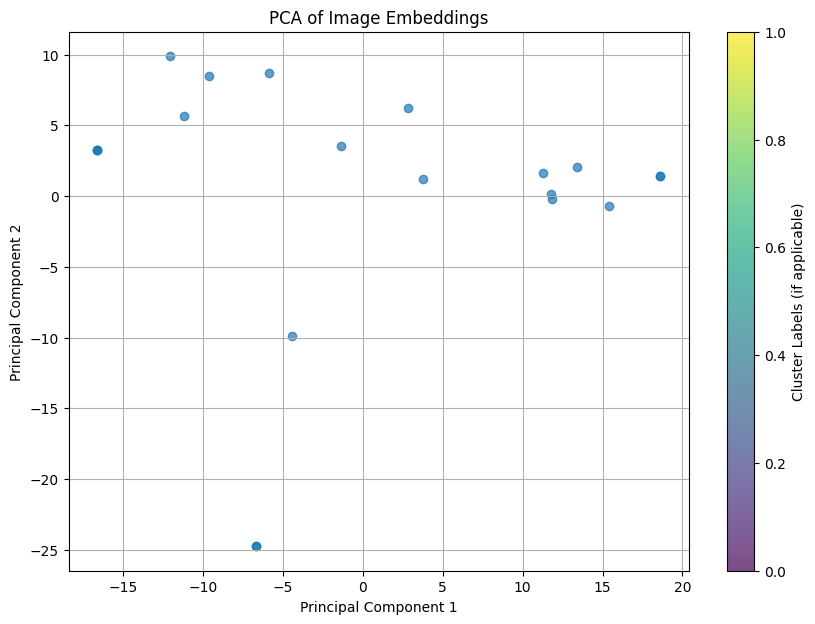

In [49]:
# Load the DataFrame (if not already in memory)
embeddings_df = pd.read_pickle("image_embeddings.pkl")  # Uncomment if loading from file

# Extract embeddings into a numpy array
embeddings = np.stack(embeddings_df["embeddings"].values)

# Perform PCA
pca = PCA(n_components=12)  # Adjust n_components as needed (2D for visualization)
reduced_embeddings = pca.fit_transform(embeddings)

# Add PCA results to the DataFrame
embeddings_df["pca_1"] = reduced_embeddings[:, 0]
embeddings_df["pca_2"] = reduced_embeddings[:, 1]

# Print explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Plot the PCA results
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    embeddings_df["pca_1"], embeddings_df["pca_2"], c=None, cmap="viridis", alpha=0.7
)
plt.colorbar(scatter, label="Cluster Labels (if applicable)")
plt.title("PCA of Image Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()

# Save PCA DataFrame
embeddings_df.to_csv("image_embeddings_with_pca.csv", index=False)


In [ ]:
# Try tsne dimensionality reduction

## Clustering by K-means 

In [54]:
from sklearn.cluster import KMeans

# Extract embeddings for each selected image
embeddings_list = []
for image_path in selected_images:
    vgg_embeddings = get_embeddings(vgg, image_path)
    embeddings_list.append(vgg_embeddings.squeeze().numpy())  # Remove batch dimension and convert to numpy array

# Convert embeddings list to a numpy array
embeddings_array = np.array(embeddings_list)

# Perform K-Means clustering
num_clusters = 10  # Set the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=1000)
kmeans.fit(reduced_embeddings)

# Print cluster assignments for each image
for image_path, cluster in zip(selected_images, kmeans.labels_):
    print(f"Image: {image_path} -> Cluster: {cluster}")

Image: C:\Users\fmaca\OneDrive - Universidade de Lisboa\5º Ano, 1º Semestre\03 - Data Analysis and AI\03 - STREET Project\STREET - Mirror\London_UK\images\image_6_s_a.png -> Cluster: 2
Image: C:\Users\fmaca\OneDrive - Universidade de Lisboa\5º Ano, 1º Semestre\03 - Data Analysis and AI\03 - STREET Project\STREET - Mirror\London_UK\images\image_9_s_b.png -> Cluster: 5
Image: C:\Users\fmaca\OneDrive - Universidade de Lisboa\5º Ano, 1º Semestre\03 - Data Analysis and AI\03 - STREET Project\STREET - Mirror\London_UK\images\image_4_b.png -> Cluster: 1
Image: C:\Users\fmaca\OneDrive - Universidade de Lisboa\5º Ano, 1º Semestre\03 - Data Analysis and AI\03 - STREET Project\STREET - Mirror\London_UK\images\image_13_s_a.png -> Cluster: 7
Image: C:\Users\fmaca\OneDrive - Universidade de Lisboa\5º Ano, 1º Semestre\03 - Data Analysis and AI\03 - STREET Project\STREET - Mirror\London_UK\images\image_7_s_a.png -> Cluster: 6
Image: C:\Users\fmaca\OneDrive - Universidade de Lisboa\5º Ano, 1º Semestre\

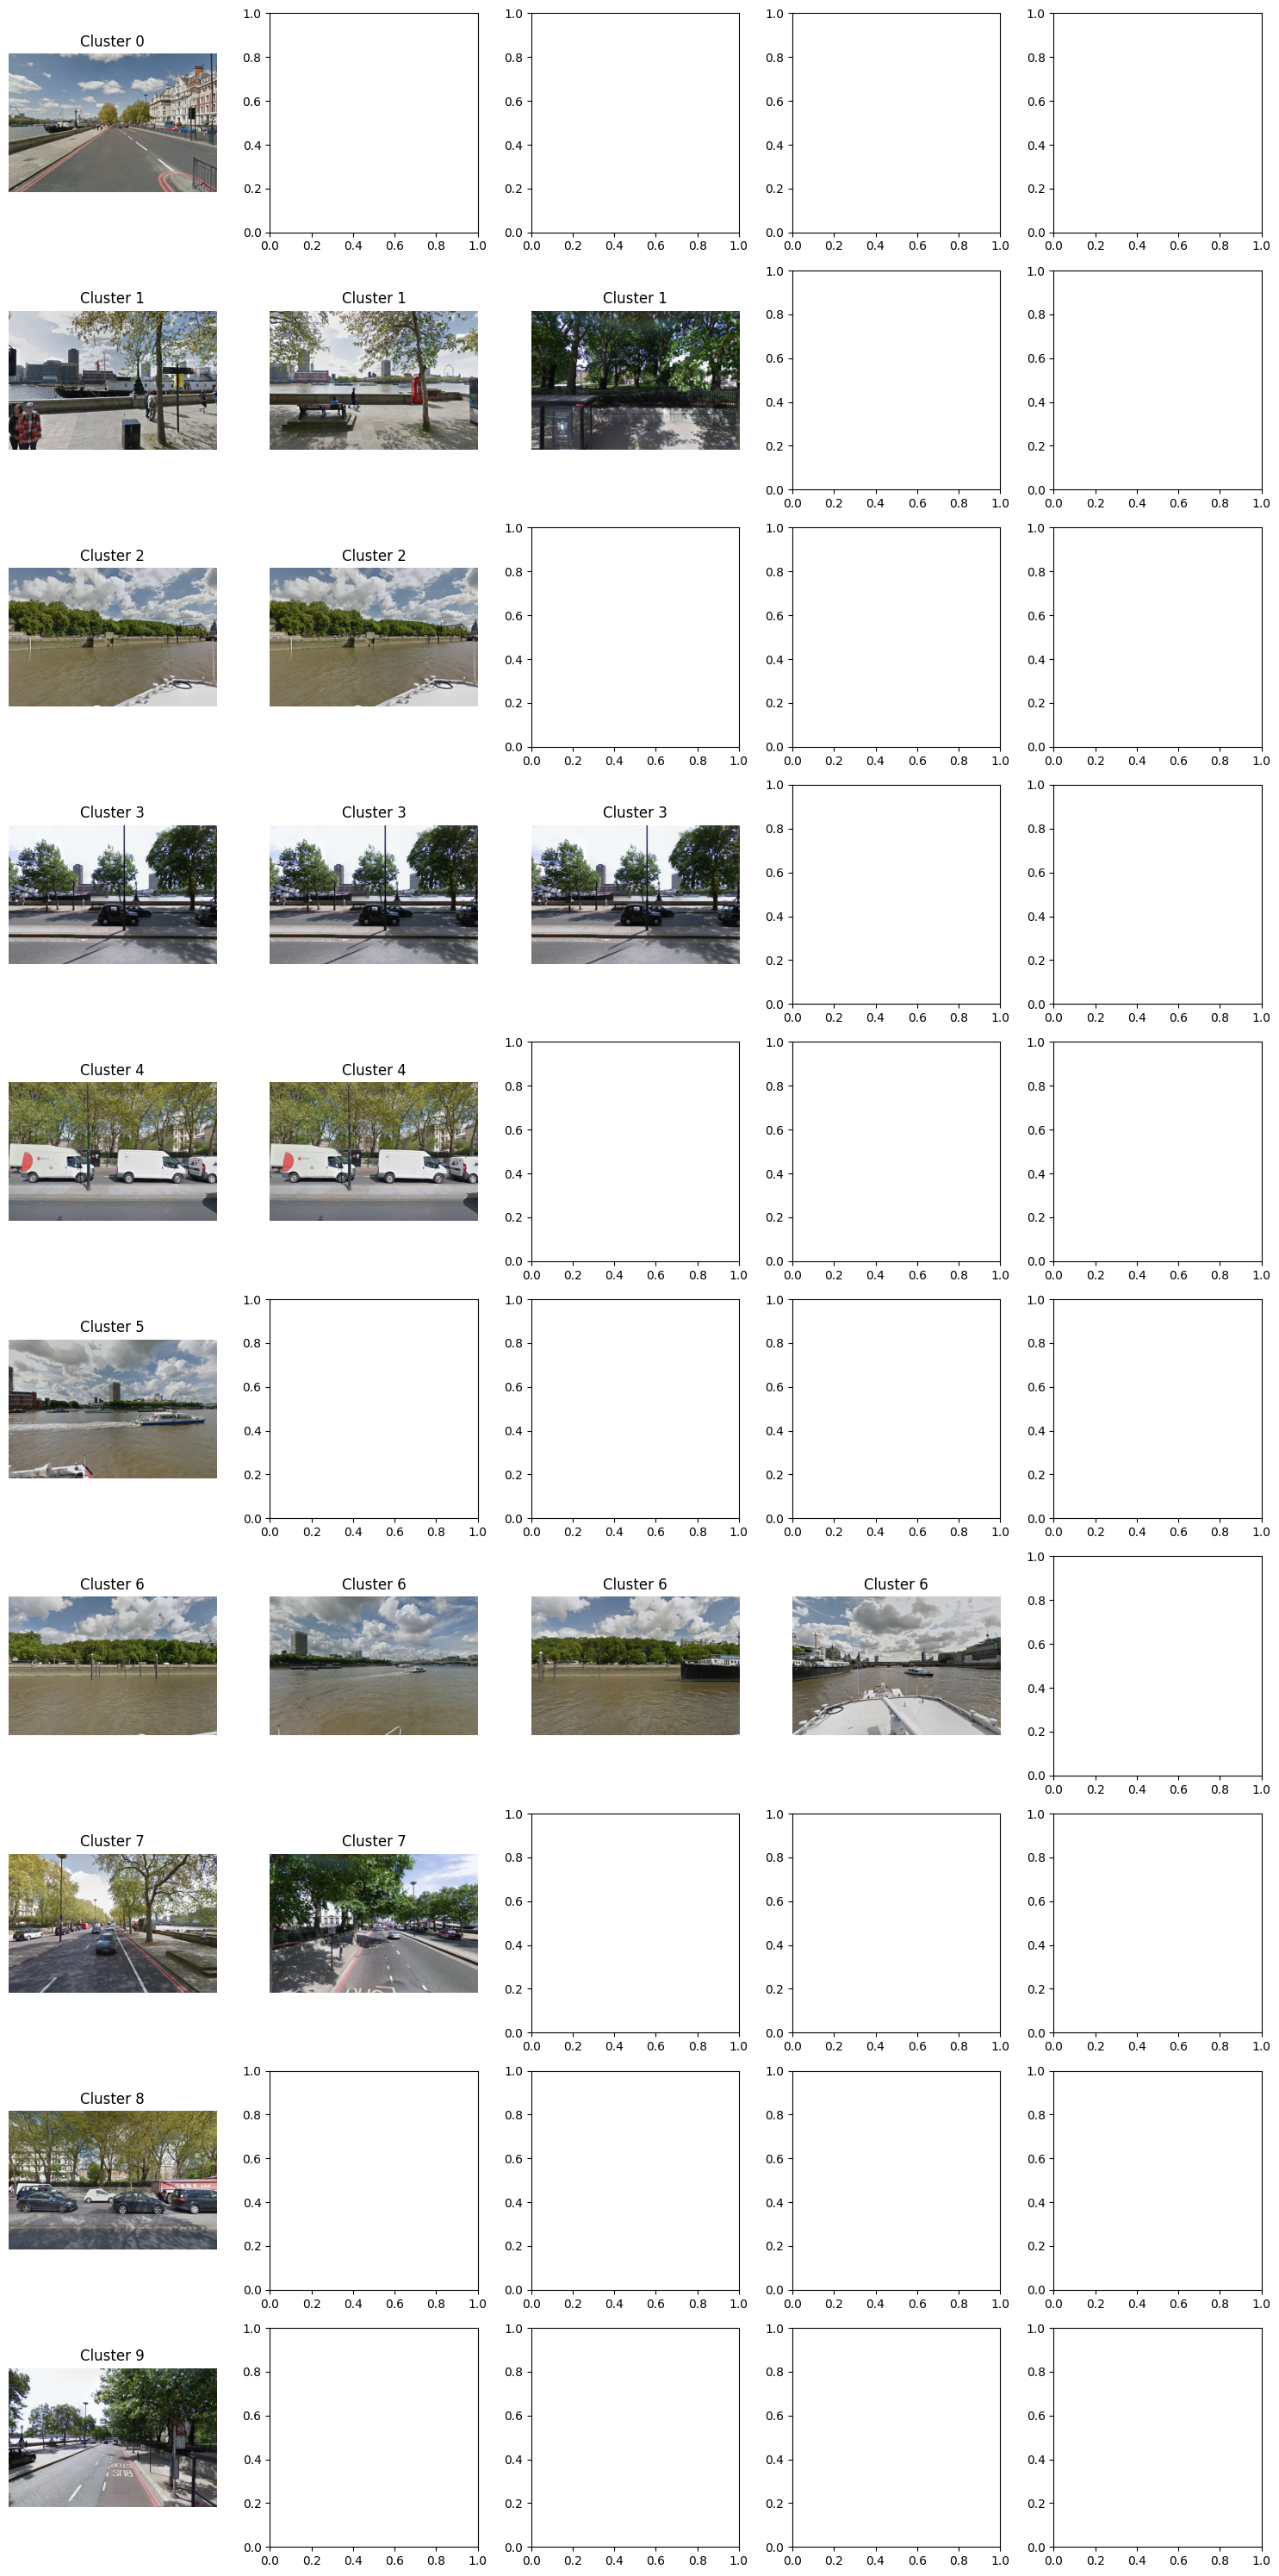

In [55]:
# Function to plot images from each cluster
def plot_clusters(selected_images, labels, num_clusters):
    fig, axes = plt.subplots(num_clusters, 5, figsize=(15, num_clusters * 3))
    for cluster in range(num_clusters):
        cluster_images = [img for img, label in zip(selected_images, labels) if label == cluster]
        for i, image_path in enumerate(cluster_images[:5]):  # Show up to 5 images per cluster
            image = Image.open(image_path)
            ax = axes[cluster, i]
            ax.imshow(image)
            ax.axis('off')
            ax.set_title(f"Cluster {cluster}")
    plt.tight_layout()
    plt.show()

# Plot images from each cluster
plot_clusters(selected_images, kmeans.labels_, num_clusters)